In [1]:
import numpy as np; import pylab as pl; import os, time, pickle; import matplotlib.pyplot as plt
ITD_limit = 160
stim_no = 33
stim_range = np.arange(-ITD_limit, ITD_limit, 2*ITD_limit/stim_no)
N = 12500
simtime = 1*1000.
t_trans = 150.
f = open('po_init', 'rb'); pitds = pickle.load(f); f.close()
po_init=pitds

n_cores = 4
trial_no = 20
tr=0

In [2]:
import neo
import elephant.statistics as stats
import quantities as pq

In [3]:
raiz = 'Results/N12500g8_Jrec=0.01/spikes-all-st{stim}-tr{tr}-12501-{core}.dat'
stim = 0

In [4]:
def pega_resultados(raiz, tr=0, stim=0):
    spkt = []
    for core in range(n_cores):
        spkt.append(np.loadtxt(raiz.format(core=core, tr=tr, stim=stim), skiprows=3))
    return np.concatenate(spkt)
    
def generate_spktm(file):
    spike_trains_matrix = {}
    for st in range(len(stim_range)):
        spike_trains = [file[:,1][np.where(file[:,0]==n)[0]] for n in range(1,N+1)]
        spike_trains_matrix[str(st)] = spike_trains

    return spike_trains_matrix

def plot_raster(spike_time_matrix, fig_size=(20,10)):
    plt.figure(figsize=fig_size)
    for i in range(int(N*0.8)):
        if len(spike_time_matrix[i]) != 0:
            plt.plot(spike_time_matrix[i], i*np.ones(len(spike_time_matrix[i])),"o", c="r", markersize=1)
    for i in range(int(N*0.8),N):
        if len(spike_time_matrix[i]) != 0:
            plt.plot(spike_time_matrix[i], i*np.ones(len(spike_time_matrix[i])),"o", c="b", markersize=1)

def calculate_fr(file):
    senders = file[:,0]
    fr = np.array([len(np.where(senders == n)[0]) / ((simtime-t_trans)/1000) for n in range(1,N+1)])
    return fr

def compute_inst_fr(spike_time_matrix):
    neo_spktm = [neo.SpikeTrain(spike_time_matrix[n], t_stop=1000*pq.ms, units="ms") for n in range(N)]

    # Compute and plot the PSTH
    bin_size = 10 * pq.ms

    psth_exc = stats.time_histogram(neo_spktm[:int(N*0.8)], bin_size, output='rate')
    psth_inh = stats.time_histogram(neo_spktm[int(N*0.8):], bin_size, output='rate')
    fig, ax = plt.subplots(1, 1, figsize=(20,2))
    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Firing rate (Hz)")
    plt.plot(psth_exc.times.rescale('s'), psth_exc.rescale('Hz'),'r')
    plt.plot(psth_inh.times.rescale('s'), psth_inh.rescale('Hz'),'b')
    plt.show()

In [5]:
file = pega_resultados(raiz)

In [6]:
spktm = generate_spktm(file)

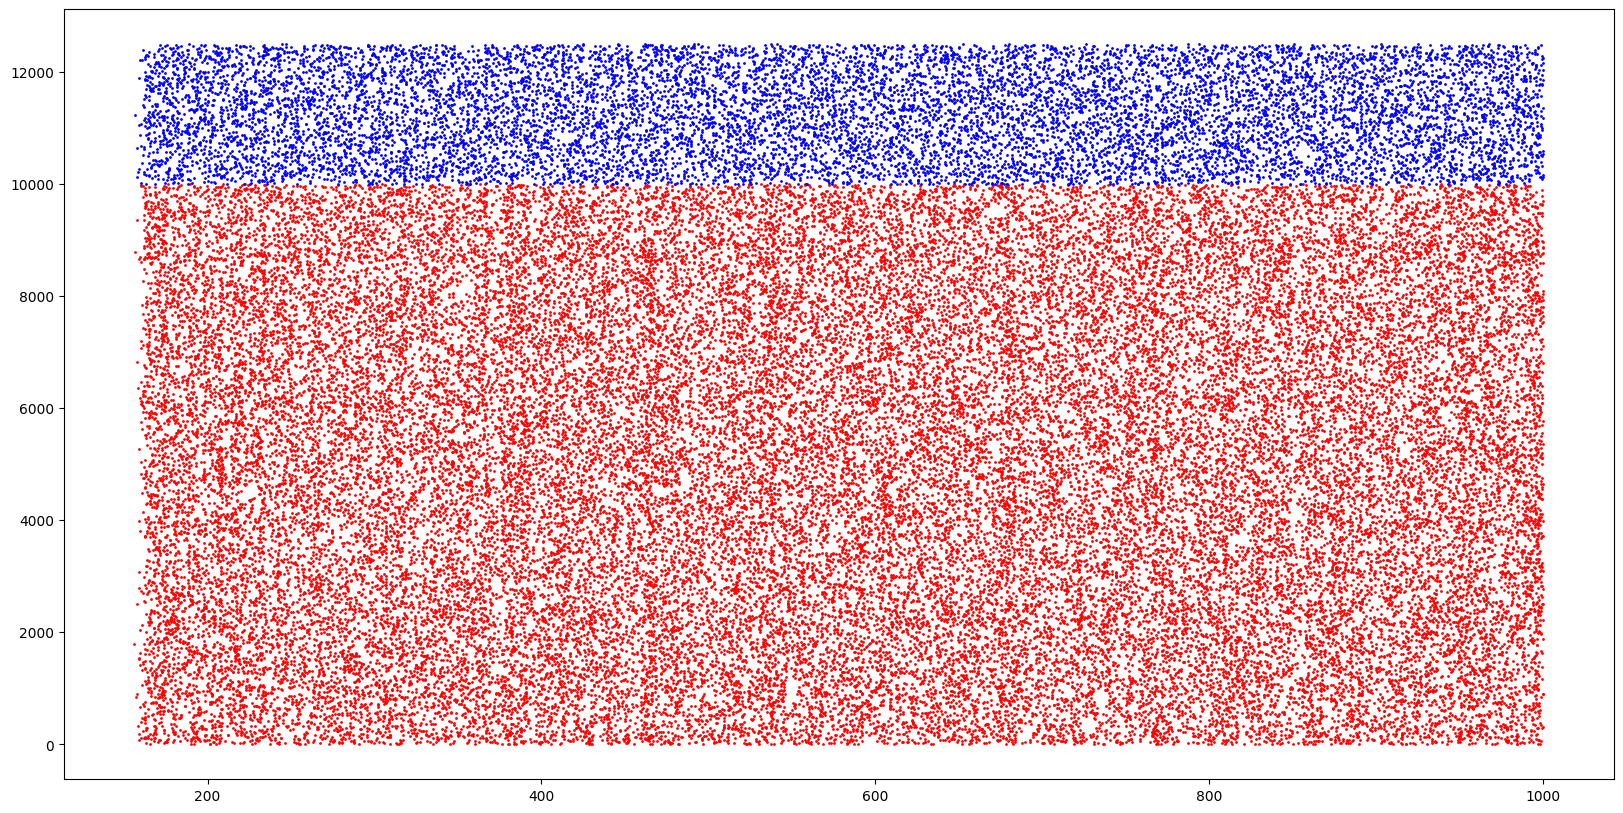

In [7]:
plot_raster(spktm['0'])

In [8]:
frs = calculate_fr(file)

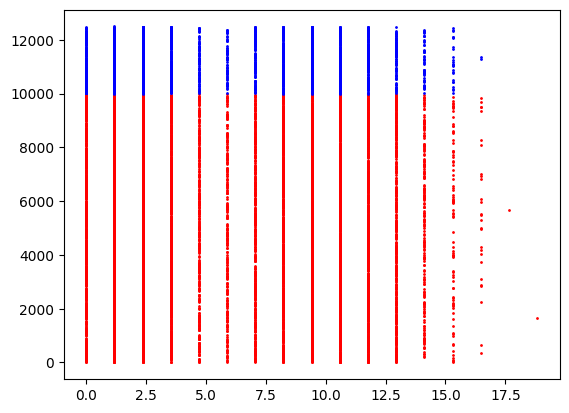

In [9]:
for i in range(int(N*0.8)):
    plt.plot(frs[i], i,"o", c="r", markersize=1)
for i in range(int(N*0.8),N):
    plt.plot(frs[i], i,"o", c="b", markersize=1)

/home/lavinia-lascon/anaconda3/envs/lascon/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 4 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "


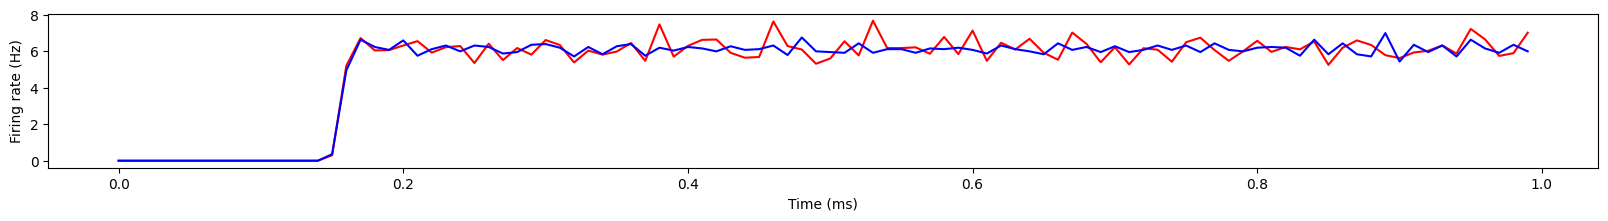

In [10]:
compute_inst_fr(spktm['0'])

## Getting data from the full experiment

In [11]:
files = []

for tr in range(trial_no):
    file = []
    for stim in range(stim_no):
        file.append(pega_resultados(raiz, tr, stim))
    files.append(file)
    

In [12]:
def generate_TC(file):
    tc = []
    for st in range(len(stim_range)):
        fr = calculate_fr(file[st])
        tc.append(fr)
    return tc

def gen_all_TC(files):
    tcs = []
    for tr in range(trial_no):
        tc = generate_TC(files[tr])
        print(tr)
        tcs.append(tc)
    return tcs

In [13]:
def plot_TC(tc, neurons, label=po_init):
    for neuron in neurons:
        plt.plot(stim_range[:], tc[:,neuron], 'o-', label=round(label[neuron],1))
        plt.xlabel("ITD Estimulo (ms)")
        plt.ylabel("Taxa de disparo (spike/s)")
    plt.legend(bbox_to_anchor=(1.25,1))

In [14]:
#tcs = gen_all_TC(files)
#file = open('tcs_Jrec=0.01', 'wb'); pickle.dump(tcs, file); file.close()

In [15]:
f = open('tcs_Jrec=0.01', 'rb'); tcs = pickle.load(f); f.close()

In [16]:
np.shape(np.array(tcs)[0,:,0])

(33,)

In [17]:
np.shape(tcs)

(20, 33, 12500)

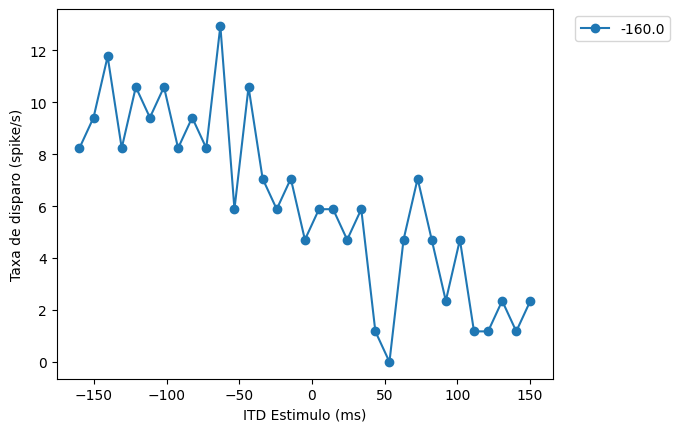

In [18]:
plot_TC(np.array(tcs)[0],range(1,2))

In [19]:
tc_mean = np.mean(tcs, axis=0)

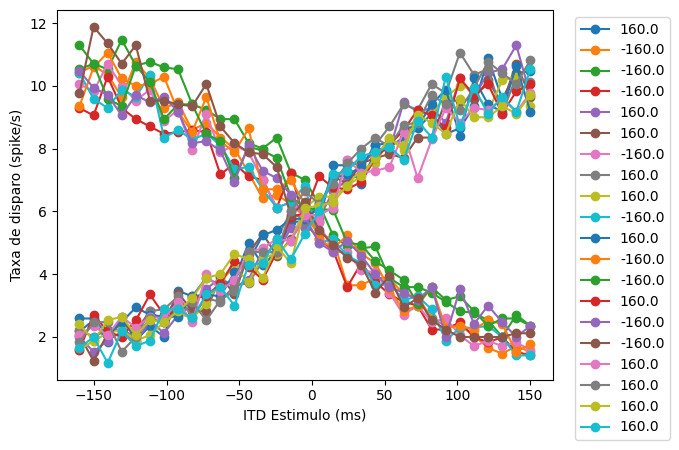

In [20]:
plot_TC(tc_mean, range(800,820))

In [21]:
po_output = []
for n in range(N):
    poo = list(tc_mean[:,n]).index(max(tc_mean[:,n]))
    po_output.append(np.mean(stim_range[poo]))

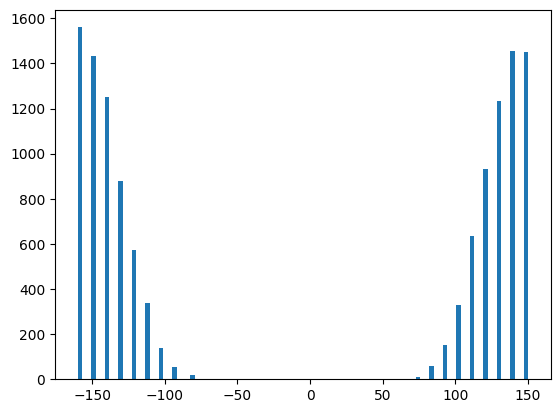

In [22]:
plt.hist(np.array(po_output), bins = 100);

## Sorting

In [23]:
poo_idx = np.argsort(np.array(po_output), axis=-1, kind=None, order=None)

In [24]:
poo_idx

array([10630, 10636, 10573, ...,    64,  5689,  5688])

In [25]:
#po_output[poo_idx]

sorted_spktm = [po_output[n] for n in poo_idx]

In [26]:
sorted_spktm = [spktm['0'][n] for n in poo_idx]

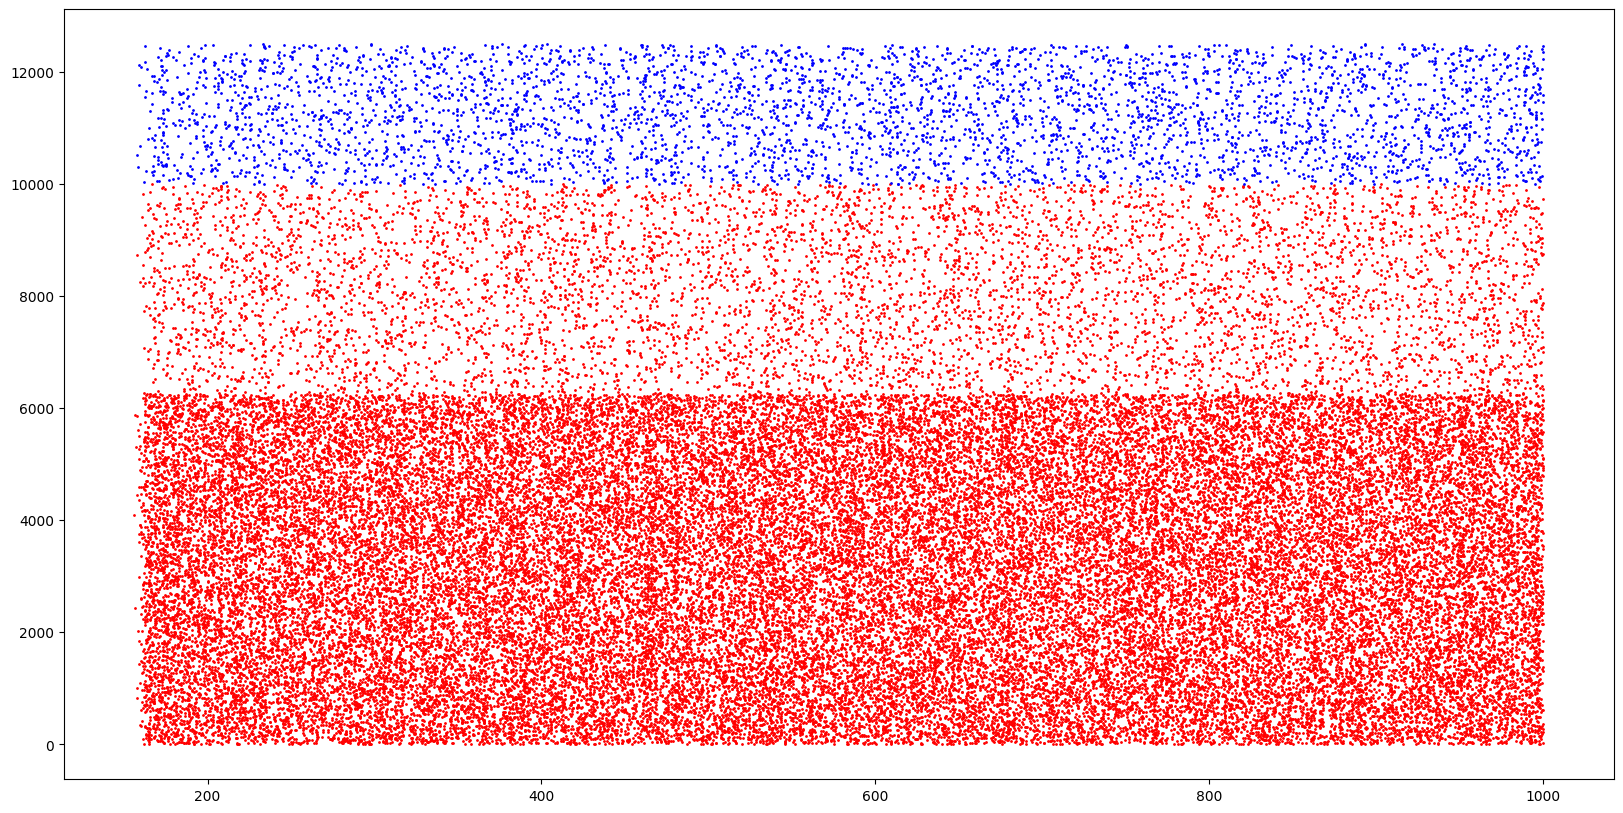

In [27]:
plot_raster(sorted_spktm)